In [53]:
import time
import os
from os.path import join
import sys
import pandas as pd
import nibabel.freesurfer
from pathlib import Path

import numpy as np
import pyvista as pv
import torch

In [54]:
structure_id = 17  # Left-Hippocampus
brain_structure_filename = f"resliced_mesh_{structure_id}"
shapes_dir = Path('/Users/sak/.herbrain/data/pregnancy/neuromaternal_madrid_2021/derivatives/enigma_shape')

In [55]:
def nibabel_to_pyvista(mesh):
    V, F = mesh
    faces = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, faces)

In [56]:
import re

all_subject_meshes = {}

# Extract unique subject IDs
subject_ids = set()
for subdir in os.listdir(shapes_dir):
    # print(subdir)
    match = re.match(r"sub-(\w+)_ses-[34]", subdir)
    if match:
        # print("match!")
        subject_ids.add(match.group(1))

print(subject_ids)
print(len(subject_ids))
# session 3 corresponds to our 't0', meaning the data from the third trimester pregnancy
# session 4 corresponds to our 't1', meaning the postpartum data
for subject_id in sorted(subject_ids):
    sub_meshes = {}
    
    ses3_path = shapes_dir / f"sub-{subject_id}_ses-3" / "resliced_mesh_17"
    ses4_path = shapes_dir / f"sub-{subject_id}_ses-4" / "resliced_mesh_17"

    if not ses3_path.exists() or not ses4_path.exists():
        print("HELP :(")
        continue

    mesh3 = nibabel.freesurfer.read_geometry(str(ses3_path))
    mesh4 = nibabel.freesurfer.read_geometry(str(ses4_path))

    pv_mesh3 = nibabel_to_pyvista(mesh3)
    pv_mesh4 = nibabel_to_pyvista(mesh4)

    # Align ses-4 to ses-3
    aligned_mesh4 = pv_mesh4.align(
        pv_mesh3,
        max_landmarks=100,
        max_mean_distance=1e-5,
        max_iterations=500,
        check_mean_distance=True,
        start_by_matching_centroids=True,
    )

    sub_meshes['t0'] = pv_mesh3
    sub_meshes['t1'] = aligned_mesh4
    all_subject_meshes[subject_id] = sub_meshes

{'3c4a4a2b19', 'c22eebaf68', 'ed2a398ef5', 'a0131fa8b8', '3c92b464a0', '863991917d', '1db8e32656', 'c7b1145ac8', '5e867e35e6', 'b62f625bc7', '690eec56c3', 'bf576701af', '57622fa0f9', 'b837585268', 'aba25b512d', 'f209c3fa4b', '3f68c4406d', 'efe5f05d66', '84be77a9cb', '7bd2334282', '3f751fe2c2', 'a5e6bbb4e1', '90e636662e', '96fab186d7', '5c1ae9ac67', '945e4ab297', '26e0dc601b', '082dc070c1', 'e85fe1cf8a', '717e805d07', 'c9a0ecdb96', 'e28f20c1bf', '4abde43b71', '2edf82ffc5', '15901c4398', '073801a359', 'a7a60575c7', '74ad7c8895', 'b627a7c635', 'a8fd90daa4', '4c1ea69777', '718923d847', '0872b8db24', '343a5d44e7', 'e0e4067b5d', '593ac50159', '810e8bcfc7', '049ab1a591', '11a123772c', 'c01a46c7f9', 'c1be0ff860', '47fb269f0c', 'c4c18afc24', 'd367eabca4', 'e72d2b2eff', '085a9ee2fc', '4f7098b19c', '6733e7702c', '31879f2221', 'ba9ede24d1', '22cdbe0c1b', '306d3a97b3', '7368c7582b', '59580b610d', '2d086560ad', 'ddc64ac56d', '8029be34e5', 'ff91cacb30', '948e10968e', 'a32661b55d', '7304a751ea', 'ed88

In [84]:
# load depression scores 
df = pd.read_csv("/Users/sak/.herbrain/data/pregnancy/old/czi_data_1st_upload_hggm/neuromaternal_madrid_2021/rawdata/participants_long_czi.tsv", sep='\t')

# make column with only participant id (remove 'sub-')
df['participant_id_clean'] = df['participant_id'].str.replace('sub-', '', regex=False)


In [85]:
def average_pyvista_meshes(meshes):
    n_points = meshes[0].n_points
    
    stacked_vertices = np.stack([mesh.points for mesh in meshes if mesh is not None], axis=0)  # shape (n, m, 3)
    average_vertices = np.mean(stacked_vertices, axis=0)  # shape (m, 3)
    
    averaged_mesh = pv.PolyData(average_vertices, meshes[0].faces)
    
    return averaged_mesh

meshes = [all_subject_meshes[sub_id]['t0'] if sub_id in all_subject_meshes else print(f"Missing: {sub_id}") for sub_id in healthy_mothers_ids]
# print(meshes)

average_brain = average_pyvista_meshes(meshes)

plotter = pv.Plotter()
plotter.add_mesh(average_mesh, color="red", opacity=0.5)
plotter.show()

Missing: 945e4ab297


Widget(value='<iframe src="http://localhost:65069/index.html?ui=P_0x32cd65090_7&reconnect=auto" class="pyvista…

In [86]:
trajectories = {}

for sub_id in all_subject_meshes:
    t1_mesh = all_subject_meshes[sub_id]['t1']
    
    # Compute the vertex-wise difference
    difference = t1_mesh.points - average_brain.points
    
    difference_mesh = average_brain.copy()
    difference_mesh['displacement'] = difference
    
    trajectories[sub_id] = difference_mesh


In [87]:
def compute_average_displacement(trajectory_mesh):
    disp_vectors = trajectory_mesh['displacement']
    magnitudes = np.linalg.norm(disp_vectors, axis=1) 
    return np.mean(magnitudes)

In [88]:
'''
EDS.Total is edinburgh depression score
right now i am only using the EDS from the second session (ses-4) to filter the depression diagnosis --
    my reasoning is that indicator of postpartum depression will be the score from the postpartum session even though they record it in the pregnant session as well

TODO: in the data, some mothers depression score increases and some decreases between sessions. some changes in score make diagnosis change -- e.g.:
    mother1 could be healthy in ses-3 and depressed in ses-4
    mother2 could be depressed in ses-3 and healthy in ses-4
    mother3 could be healthy in both sessions
    mother4 could be depressed in both sessions
    
how do we want to handle this in analysis?
'''

# filter for healthy mothers in ses-4 with EDS < 10
healthy_df = df[
    (df['group'] == 'mother') &
    (df['EDS.Total'] < 10.) &
    (df['participant_id_ses'].str.endswith('ses-4'))
]

# only keep rows where we have trajectories
healthy_df = healthy_df[healthy_df['participant_id_clean'].isin(trajectories.keys())]

# now get EDS values 
healthy_magnitudes = []
healthy_eds_values = []

for _, row in healthy_df.iterrows():
    sub_id = row['participant_id_clean']
    if sub_id in trajectories:
        healthy_magnitudes.append(compute_average_displacement(trajectories[sub_id]))
        healthy_eds_values.append(row['EDS.Total'])

depressed_df = df[
    (df['group'] == 'mother') &
    (df['EDS.Total'] >= 10.) &
    (df['participant_id_ses'].str.endswith('ses-4'))
]

depressed_df = depressed_df[depressed_df['participant_id_clean'].isin(trajectories.keys())]

depressed_magnitudes = []
depressed_eds_values = []

for _, row in depressed_df.iterrows():
    sub_id = row['participant_id_clean']
    if sub_id in trajectories:
        depressed_magnitudes.append(compute_average_displacement(trajectories[sub_id]))
        depressed_eds_values.append(row['EDS.Total'])

In [89]:
# convert to numpy arrays
X_healthy = np.array(healthy_magnitudes).reshape(-1, 1)
y_healthy = np.array(healthy_eds_values)

X_depressed = np.array(depressed_magnitudes).reshape(-1, 1)
y_depressed = np.array(depressed_eds_values)

Healthy group:
  Slope: -0.104
  Intercept: 4.123
  R-squared: 0.003
Depressed group:
  Slope: -0.405
  Intercept: 14.784
  R-squared: 0.023


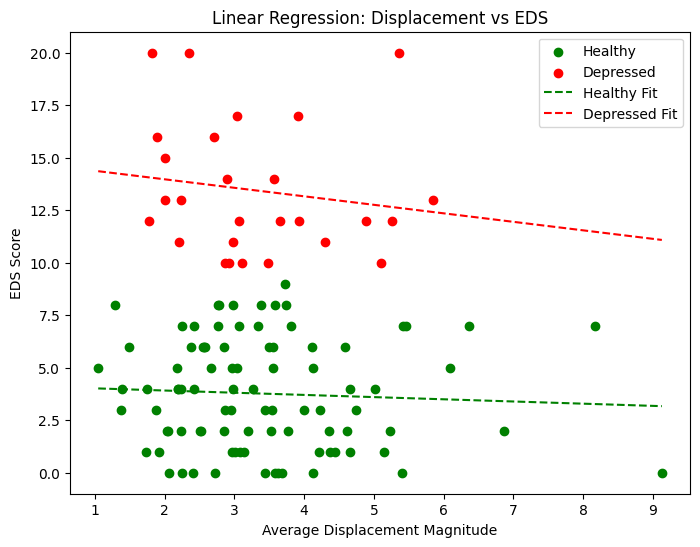

In [90]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# fit separate linear regressions
healthy_model = LinearRegression()
healthy_model.fit(X_healthy, y_healthy)

depressed_model = LinearRegression()
depressed_model.fit(X_depressed, y_depressed)

# slopes, intercepts, R-squared
print("Healthy group:")
print(f"  Slope: {healthy_model.coef_[0]:.3f}")
print(f"  Intercept: {healthy_model.intercept_:.3f}")
print(f"  R-squared: {healthy_model.score(X_healthy, y_healthy):.3f}")

print("Depressed group:")
print(f"  Slope: {depressed_model.coef_[0]:.3f}")
print(f"  Intercept: {depressed_model.intercept_:.3f}")
print(f"  R-squared: {depressed_model.score(X_depressed, y_depressed):.3f}")

plt.figure(figsize=(8, 6))

# Plot
plt.scatter(healthy_magnitudes, healthy_eds_values, color='green', label='Healthy')
plt.scatter(depressed_magnitudes, depressed_eds_values, color='red', label='Depressed')

# regression lines
x_vals = np.linspace(min(healthy_magnitudes + depressed_magnitudes),
                      max(healthy_magnitudes + depressed_magnitudes), 100).reshape(-1, 1)

plt.plot(x_vals, healthy_model.predict(x_vals), color='green', linestyle='--', label='Healthy Fit')
plt.plot(x_vals, depressed_model.predict(x_vals), color='red', linestyle='--', label='Depressed Fit')

plt.xlabel('Average Displacement Magnitude')
plt.ylabel('EDS Score')
plt.title('Linear Regression: Displacement vs EDS')
plt.legend()
plt.show()
